In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('../../raw/LiChuan/Dec_Basic_feature.csv')
test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [32]:
#train = train[['class_id', "sale_date", 'sale_quantity', 'how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','year','month']]
#test = test[['class_id', "sale_date", 'how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','year','month']]

## 时间转换

In [4]:
train['sale_date'] = train['year'] * 100 + train['month']
train['sale_date'] = train['sale_date'].astype(int)
train['sale_date'] = pd.to_datetime(train['sale_date'],format='%Y%m',errors = "coerce")
train['sale_date'] = train['sale_date'].dt.to_period('m')

In [5]:
train['sale_date'][0] + 1

Period('2012-02', 'M')

In [35]:
test['sale_date'] = test['sale_date'].astype(int)
test['sale_date'] = pd.to_datetime(test['sale_date'],format='%Y%m',errors = "coerce")
test['sale_date'] = test['sale_date'].dt.to_period('M')

In [36]:
test['sale_date'][0]

Period('2017-11', 'M')

In [6]:
train.shape

(10080, 163)

In [38]:
train = pd.concat([train, test]).reset_index(drop=True)
train.fillna(0, inplace=True)
train.shape

(9940, 163)

## 窗口函数

In [7]:
def sale_cal_sum(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

In [8]:
def sale_cal_max(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).agg(max).sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

In [9]:
def sale_cal_min(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).agg(min).sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

In [10]:
def sale_cal_mean(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).mean().sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

In [11]:
def sale_cal_median(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).median().sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

In [12]:
def sale_cal_std(train,window,num):
    traintmp = pd.DataFrame()
    for i in range(num):          
        trainSaletmp = train[train['sale_date'].isin(window)]
        trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
        trainSaletmp = trainSaletmp.groupby(['class_id']).std().sale_quantity.reset_index() #更换所需的函数
        trainSaletmp['sale_date'] = window[0]+1
        if i == 0:
            traintmp = trainSaletmp
        else:
            traintmp = pd.concat([traintmp, trainSaletmp])    
        for j,k in enumerate(window):
            window[j] = window[j] + 1
    return traintmp

## 计算近 3 个月数据

In [13]:
i = train['sale_date'][0]+2  #从2012-4开始计算
window=[i,i-1,i-2]           #更换窗口
window

[Period('2012-03', 'M'), Period('2012-02', 'M'), Period('2012-01', 'M')]

In [17]:
window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_sum = sale_cal_sum(train,window,69) #计算近3个月的数据总共需要计算69个月
train_last_3M_sum.rename(columns={'sale_quantity': 'sale_quantity_last_3M_sum'}, inplace=True)# 替换列名称

window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_max = sale_cal_max(train,window,69)
train_last_3M_max.rename(columns={'sale_quantity': 'sale_quantity_last_3M_max'}, inplace=True)# 替换列名称

window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_min = sale_cal_min(train,window,69)
train_last_3M_min.rename(columns={'sale_quantity': 'sale_quantity_last_3M_min'}, inplace=True)# 替换列名称

window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_mean = sale_cal_mean(train,window,69)
train_last_3M_mean.rename(columns={'sale_quantity': 'sale_quantity_last_3M_mean'}, inplace=True)# 替换列名称

window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_std = sale_cal_std(train,window,69)
train_last_3M_std.rename(columns={'sale_quantity': 'sale_quantity_last_3M_std'}, inplace=True)# 替换列名称

window=[i,i-1,i-2] #每次计算必须重新初始化window
train_last_3M_median = sale_cal_median(train,window,69)
train_last_3M_median.rename(columns={'sale_quantity': 'sale_quantity_last_3M_median'}, inplace=True)# 替换列名称

In [18]:
# 合并
train = pd.merge(train, train_last_3M_sum, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_3M_max, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_3M_min, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_3M_mean, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_3M_std, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_3M_median, on=['class_id','sale_date'], how='left')
train.fillna(0, inplace=True)

## 计算滑动窗口为6个月的数据

In [19]:
i = train['sale_date'][0]+5  #从2012-7开始计算
window=[i,i-1,i-2,i-3,i-4,i-5] #更换窗口
window

[Period('2012-06', 'M'),
 Period('2012-05', 'M'),
 Period('2012-04', 'M'),
 Period('2012-03', 'M'),
 Period('2012-02', 'M'),
 Period('2012-01', 'M')]

In [20]:
window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_sum = sale_cal_sum(train,window,66) #计算近6个月的数据总共需要计算66个月
train_last_6M_sum.rename(columns={'sale_quantity': 'sale_quantity_last_6M_sum'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_max = sale_cal_max(train,window,66)
train_last_6M_max.rename(columns={'sale_quantity': 'sale_quantity_last_6M_max'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_min = sale_cal_min(train,window,66)
train_last_6M_min.rename(columns={'sale_quantity': 'sale_quantity_last_6M_min'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_mean = sale_cal_mean(train,window,66)
train_last_6M_mean.rename(columns={'sale_quantity': 'sale_quantity_last_6M_mean'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_std = sale_cal_std(train,window,66)
train_last_6M_std.rename(columns={'sale_quantity': 'sale_quantity_last_6M_std'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5] #每次计算必须重新初始化window
train_last_6M_median = sale_cal_median(train,window,66)
train_last_6M_median.rename(columns={'sale_quantity': 'sale_quantity_last_6M_median'}, inplace=True)# 替换列名称

In [21]:
# 合并
train = pd.merge(train, train_last_6M_sum, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_6M_max, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_6M_min, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_6M_mean, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_6M_std, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_6M_median, on=['class_id','sale_date'], how='left')
train.fillna(0, inplace=True)

## 计算滑动窗口为 2 个月的数据

In [22]:
i = train['sale_date'][0]+1  #从2012-2开始计算
window=[i,i-1] #更换窗口
window

[Period('2012-02', 'M'), Period('2012-01', 'M')]

In [23]:
window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_sum = sale_cal_sum(train,window,70) #计算近2个月的数据总共需要计算64个月
train_last_2M_sum.rename(columns={'sale_quantity': 'sale_quantity_last_2M_sum'}, inplace=True)# 替换列名称

window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_max = sale_cal_max(train,window,70)
train_last_2M_max.rename(columns={'sale_quantity': 'sale_quantity_last_2M_max'}, inplace=True)# 替换列名称

window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_min = sale_cal_min(train,window,70)
train_last_2M_min.rename(columns={'sale_quantity': 'sale_quantity_last_2M_min'}, inplace=True)# 替换列名称

window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_mean = sale_cal_mean(train,window,70)
train_last_2M_mean.rename(columns={'sale_quantity': 'sale_quantity_last_2M_mean'}, inplace=True)# 替换列名称

window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_std = sale_cal_std(train,window,70)
train_last_2M_std.rename(columns={'sale_quantity': 'sale_quantity_last_2M_std'}, inplace=True)# 替换列名称

window=[i,i-1] #每次计算必须重新初始化window
train_last_2M_median = sale_cal_median(train,window,70)
train_last_2M_median.rename(columns={'sale_quantity': 'sale_quantity_last_2M_median'}, inplace=True)# 替换列名称

In [24]:
# 合并
train = pd.merge(train, train_last_2M_sum, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_2M_max, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_2M_min, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_2M_mean, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_2M_std, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_2M_median, on=['class_id','sale_date'], how='left')
train.fillna(0, inplace=True)

## 计算滑动窗口为 12 个月的数据

In [25]:
i = train['sale_date'][0]+11  #从2013-1开始计算
window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #更换窗口
window

[Period('2012-12', 'M'),
 Period('2012-11', 'M'),
 Period('2012-10', 'M'),
 Period('2012-09', 'M'),
 Period('2012-08', 'M'),
 Period('2012-07', 'M'),
 Period('2012-06', 'M'),
 Period('2012-05', 'M'),
 Period('2012-04', 'M'),
 Period('2012-03', 'M'),
 Period('2012-02', 'M'),
 Period('2012-01', 'M')]

In [26]:
window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_sum = sale_cal_sum(train,window,60) #计算近12个月的数据总共需要计算58个月
train_last_12M_sum.rename(columns={'sale_quantity': 'sale_quantity_last_12M_sum'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_max = sale_cal_max(train,window,60)
train_last_12M_max.rename(columns={'sale_quantity': 'sale_quantity_last_12M_max'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_min = sale_cal_min(train,window,60)
train_last_12M_min.rename(columns={'sale_quantity': 'sale_quantity_last_12M_min'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_mean = sale_cal_mean(train,window,60)
train_last_12M_mean.rename(columns={'sale_quantity': 'sale_quantity_last_12M_mean'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_std = sale_cal_std(train,window,60)
train_last_12M_std.rename(columns={'sale_quantity': 'sale_quantity_last_12M_std'}, inplace=True)# 替换列名称

window=[i,i-1,i-2,i-3,i-4,i-5,i-6,i-7,i-8,i-9,i-10,i-11] #每次计算必须重新初始化window
train_last_12M_median = sale_cal_median(train,window,60)
train_last_12M_median.rename(columns={'sale_quantity': 'sale_quantity_last_12M_median'}, inplace=True)# 替换列名称

In [27]:
# 合并
train = pd.merge(train, train_last_12M_sum, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_12M_max, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_12M_min, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_12M_mean, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_12M_std, on=['class_id','sale_date'], how='left')
train = pd.merge(train, train_last_12M_median, on=['class_id','sale_date'], how='left')
train.fillna(0, inplace=True)

In [28]:
train = train.drop(['sale_quantity_this_last_year'], axis=1)

In [30]:
# 再加上同比/去年环比特征吧
train['sale_date'] = train['year'] * 100 + train['month']
train['sale_date'] = train['sale_date'].astype(int)
train['sale_date'] = pd.to_datetime(train['sale_date'],format='%Y%m',errors = "coerce")
train['sale_date'] = train['sale_date'].dt.to_period('m')

In [32]:
# 获取 12 月前的销量
i = train['sale_date'][0]+11
window = [i-11]
traintmp = pd.DataFrame()
for i in range(60):
    trainSaletmp = train[train['sale_date'].isin(window)]
    trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
    trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).sale_quantity.reset_index()
    trainSaletmp['sale_date'] = window[0]+12
    if i == 0:
        traintmp = trainSaletmp
    else:
        traintmp = pd.concat([traintmp, trainSaletmp])
    for j,k in enumerate(window):
        window[j] = window[j] + 1

In [34]:
traintmp.rename(columns={'sale_quantity': 'sale_quantity_last_12M_ago'}, inplace=True)# 替换列名称
train = pd.merge(train, traintmp, on=['class_id','sale_date'], how='left')
train['sale_quantity_last_12M_ago'].fillna(0, inplace=True)

In [35]:
# 得到销量同比/环比数据
train['month_relative_ratio'] = train['sale_quantity'] / train['sale_quantity_this_last_month']

train = train.replace([np.inf, -np.inf], np.nan) # 将 inf 转换成 nan
train['month_relative_ratio'].fillna(0, inplace=True)

In [37]:
# 获取 12 月前的环比数据
i = train['sale_date'][0]+11
window = [i-11]
traintmp = pd.DataFrame()
for i in range(60):
    trainSaletmp = train[train['sale_date'].isin(window)]
    trainSaletmp = trainSaletmp.loc[:,['class_id','month_relative_ratio']]
    trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).month_relative_ratio.reset_index()
    trainSaletmp['sale_date'] = window[0]+12
    if i == 0:
        traintmp = trainSaletmp
    else:
        traintmp = pd.concat([traintmp, trainSaletmp])
    for j,k in enumerate(window):
        window[j] = window[j] + 1

In [39]:
traintmp.rename(columns={'month_relative_ratio': 'month_relative_ratio_12M_ago'}, inplace=True)# 替换列名称
train = pd.merge(train, traintmp, on=['class_id','sale_date'], how='left')
train['month_relative_ratio_12M_ago'].fillna(0, inplace=True)

In [41]:
train = train.drop(['month_relative_ratio'], axis=1)

In [43]:
train.to_csv('../../raw/LiChuan/DecWindowFeatures.csv',index=False, header=True)

## 相关性分析

研究两个或两个以上随机变量之间相互依存关系的方向和密切程度的方法。
线性相关关系主要采用皮尔逊（Pearson）相关系数r来度量连续变量之间线性相关强度；
r>0,线性正相关；r<0,线性负相关；
r=0,两个变量之间不存在线性关系，并不代表两个变量之间不存在任何关系

![](http://img.blog.csdn.net/20170714152710193)

In [10]:
train['car_width_mean'].corr(train.car_height_mean)

0.060417735363330227

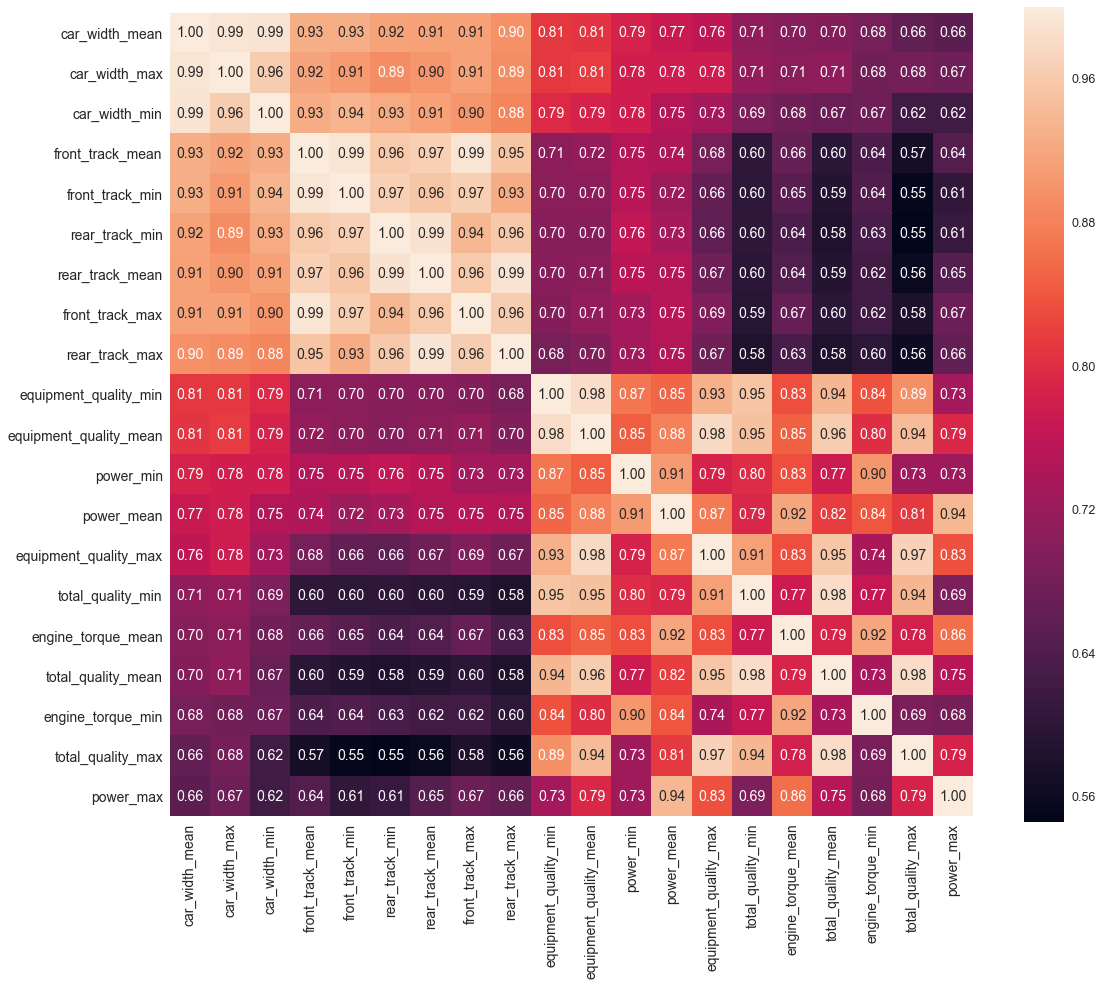

In [11]:
# 热力散点图
k = 20 #number of stdiables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'car_width_mean')['car_width_mean'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()